## Assignment 2 - Decision Tree
### Name: Vikas Vijaykumar Bastewad
### Roll Number: 20CS10073

Problem Statement: 
Decision trees are graphical models that make decisions based on conditions, branching into out-
comes or actions. They represent choices in a tree-like structure, aiding in classification or regres-
sion tasks by recursively partitioning data based on features, enabling interpretable and effective
decision-making.
For this assignment,
1. Split the dataset into 80% for training and 20% for testing. Normalize/Regularize data if
necessary. Encode categorical variables using appropriate encoding method if necessary.
2. Implement the standard ID3 Decision tree algorithm as discussed in class,using Informa-
tion Gain to choose which attribute to split at eachpoint. Stop splitting a node if it has less
than 10 data points. Do NOT use scikit-learn for this part.
3. Perform reduced error pruning operation over the tree obtained in (2). Plot a graph
showing the variation in test accuracy with varying depths. Print the pruned tree obtained
in hierarchical fashion with the attributes clearly shown at each level.
4. Report the mean macro accuracy, macro precision and macro recall for the classifier.
You may or may not use the scikit-learn implementations for computing these metrics.

In [1]:
# import all the necessary libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy


In [2]:
df = pd.read_csv('../../dataset/decision-tree.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Step 1: Data Preprocessing

In [3]:
# Spliting the dataset into training (80%) and testing (20%) sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

Step 2: Implementing ID3 Decision Tree Algorithm

In [4]:
# function to calculate entropy
def calculate_entropy(target):
    # Calculating the entropy of a binary target variable
    p_positive = len(target[target == 1]) / len(target)
    p_negative = 1 - p_positive
    
    if p_positive == 0 or p_negative == 0:
        return 0
    
    entropy = -p_positive * np.log2(p_positive) - p_negative * np.log2(p_negative)
    return entropy

In [5]:
# function to calculate Information Gain
def information_gain(data, attribute, target):
    # Calculating entropy before splitting
    entropy_before = calculate_entropy(data[target])
    
    # Calculating entropy after splitting on the attribute
    weighted_entropy = 0
    values = data[attribute].unique()
    
    for value in values:
        subset = data[data[attribute] == value]
        weighted_entropy += (len(subset) / len(data)) * calculate_entropy(subset[target])
    
    # Calculating Information Gain
    information_gain = entropy_before - weighted_entropy
    return information_gain

In [6]:
# Implementing the ID3 Decision Tree algorithm recursively
def id3(data, target, attributes):
    # Base case: Stop splitting if there are fewer than 10 data points
    if len(data) < 10:
        return data[target].mode().iloc[0]

    # Base case: Return the majority class if all data points have the same class
    if len(data[target].unique()) == 1:
        return data[target].iloc[0]

    # Calculating Information Gain for each attribute
    information_gains = {attribute: information_gain(data, attribute, target) for attribute in attributes}

    # Selecting the attribute with the highest Information Gain
    best_attribute = max(information_gains, key=information_gains.get)

    # Creating a decision tree node with the best attribute
    tree = {best_attribute: {}}

    # Recursively building the tree for each attribute value
    for value in data[best_attribute].unique():
        subset = data[data[best_attribute] == value]   
        # Removing the best attribute from the attribute set                 
        tree[best_attribute][value] = id3(subset, target, [attr for attr in attributes if attr != best_attribute])  

    return tree


In [7]:
# function to calculate the depth of decision tree
def tree_depth(tree):
    if not isinstance(tree, dict) or not tree:
        return 0
    return 1 + max(tree_depth(subtree) for subtree in tree.values())

Step 3: Reduced Error Pruning

In [8]:
def find_non_leaf_nodes(tree):
    # Find and return non-leaf nodes in the tree
    nodes = []
    for attribute, subtree in tree.items():
        if isinstance(subtree, dict):
            nodes.append(subtree)
            nodes.extend(find_non_leaf_nodes(subtree))
    return nodes

In [9]:
# function to predict the class for a single data point using the decision tree 
def predict(tree, data_point):
    for attribute, subtree in tree.items():
        value = data_point[attribute]
        if value in subtree:
            if isinstance(subtree[value], dict):
                # Continue to traverse the tree
                return predict(subtree[value], data_point)
            else:
                # Reached a leaf node, return the class label
                return subtree[value]

In [10]:
# function to evaluate the tree on the validation data and return the accuracy
def evaluate_tree(tree, validation_attributes, validation_target):
    correct_predictions = 0
    total_predictions = len(validation_target)

    for (_, row), target_value in zip(validation_attributes.iterrows(), validation_target):
        prediction = predict(tree, row)
        if prediction == target_value:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [11]:
# Implementing Reduced Error Pruning

def prune_tree(tree, validation_data, target_attribute, max_depth=None):
    # Spliting validation data into attributes and target
    validation_attributes = validation_data.drop(columns=[target_attribute])
    validation_target = validation_data[target_attribute]
    
    validation_accuracy = evaluate_tree(tree, validation_attributes, validation_target)
    pruned_tree = deepcopy(tree)  # Creating a copy of the tree for temporary pruning
    
    for node in find_non_leaf_nodes(pruned_tree):
        # Temporarily pruning the subtree below the node
        original_subtree = list(node.items())[0]  # Using list() to convert the item to a list
        node.popitem()  # Removing the last item from the node to prune the subtree
        temp_accuracy = evaluate_tree(pruned_tree, validation_attributes, validation_target)
        
        if max_depth is not None and tree_depth(pruned_tree) >= max_depth:
            # If max_depth is reached, stop pruning
            node[original_subtree[0]] = original_subtree[1]
        elif temp_accuracy >= validation_accuracy:
            node[original_subtree[0]] = original_subtree[1]

        if temp_accuracy >= validation_accuracy:    # If accuracy improves, keep the pruned subtree
            validation_accuracy = temp_accuracy     # Update the validation accuracy
        else:   # Revert to the original subtree                                        
            node[original_subtree[0]] = original_subtree[1]
    
    # Permanently pruning the node with the greatest increase in accuracy
    for node in find_non_leaf_nodes(pruned_tree):
        original_subtree = list(node.items())[0]
        node.popitem()
        temp_accuracy = evaluate_tree(pruned_tree, validation_attributes, validation_target)
        if temp_accuracy >= validation_accuracy:
            node[original_subtree[0]] = original_subtree[1]
    
    return pruned_tree

In [12]:
# Spliting the training data into training and validation sets (70% train, 30% validation) to implement pruning
train_size = int(0.7 * len(train_data))
train_set = train_data[:train_size]
validation_set = train_data[train_size:]

In [13]:
# Training the Decision Tree on the training set using ID3 algorithm
attributes = df.columns[:-1].tolist()   # List of attributes
target_attribute = 'Outcome'            # Class label
tree = id3(train_set, target_attribute, attributes) # Building the tree

In [14]:
# Pruning the Decision Tree using the validation set 
pruned_tree = prune_tree(tree, validation_set, target_attribute)    
# print(pruned_tree)

Step 4: Reporting the metrics

In [15]:
# Evaluating the pruned tree on the test data
test_predictions = [predict(pruned_tree, row) for _, row in test_data.iterrows()]
test_actual = test_data[target_attribute].tolist()

In [16]:
# Calculating and printing the metrics
def calculate_metrics(predictions, actual):
    # Calculating macro accuracy
    correct = sum(p == a for p, a in zip(predictions, actual))
    macro_accuracy = correct / len(actual)
    
    # Calculating macro precision and macro recall
    true_positives = Counter()
    false_positives = Counter()
    false_negatives = Counter()
    
    for p, a in zip(predictions, actual):
        if p == a:
            true_positives[a] += 1
        else:
            false_positives[p] += 1
            false_negatives[a] += 1
    
    macro_precision = sum(true_positives[c] / (true_positives[c] + false_positives[c]) for c in true_positives) / len(true_positives)
    macro_recall = sum(true_positives[c] / (true_positives[c] + false_negatives[c]) for c in true_positives) / len(true_positives)
    
    return macro_accuracy, macro_precision, macro_recall

macro_accuracy, macro_precision, macro_recall = calculate_metrics(test_predictions, test_actual)
print("Metrics for the pruned tree:")
print("-Mean Macro Accuracy:", macro_accuracy)
print("-Mean Macro Precision:", macro_precision)
print("-Mean Macro Recall:", macro_recall)


Metrics for the pruned tree:
-Mean Macro Accuracy: 0.18831168831168832
-Mean Macro Precision: 0.428030303030303
-Mean Macro Recall: 0.1707070707070707


Step 5: Printing the pruned tree and Plotting the graph for test accuracy with varying depths

In [17]:
# Printing the pruned decision tree
print("Pruned Decision Tree:")
print(pruned_tree)

Pruned Decision Tree:
{'DiabetesPedigreeFunction': {0.627: 1, 0.351: 0, 0.672: 1, 0.167: 0, 2.288: 1, 0.201: 0, 0.248: 0, 0.134: 0, 0.158: 1, 0.232: 1, 0.191: 0, 0.537: 1, 1.441: 0, 0.398: 1, 0.587: 0, 0.484: 1, 0.551: 1, 0.254: 1, 0.183: 0, 0.529: 1, 0.704: 0, 0.388: 0, 0.451: 1, 0.263: 0, 0.205: 0, 0.257: 1, 0.487: 0, 0.245: 0, 0.337: 1, 0.546: 0, 0.851: 1, 0.267: 0, 0.188: 0, 0.512: 0, 0.966: 0, 0.42: 0, 0.665: 1, 0.503: 1, 1.39: 1, 0.271: 0, 0.696: 0, 0.235: 0, 0.721: 1, 0.294: 0, 1.893: 1, 0.564: 0, 0.586: 0, 0.344: 1, 0.305: 0, 0.491: 0, 0.526: 0, 0.342: 0, 0.467: 1, 0.718: 0, 0.962: 0, 1.781: 0, 0.173: 0, 0.304: 0, 0.27: 1, 0.699: 0, 0.258: 0, 0.203: 0, 0.855: 1, 0.845: 0, 0.334: 0, 0.189: 0, 0.867: 1, 0.411: 0, 0.583: 1, 0.231: 0, 0.396: 0, 0.14: 0, 0.391: 0, 0.37: 0, 0.307: 0, 0.102: 0, 0.767: 0, 0.237: 0, 0.227: 1, 0.698: 0, 0.178: 0, 0.324: 0, 0.153: 1, 0.165: 0, 0.443: 0, 0.261: 0, 0.277: 1, 0.761: 0, 0.255: 0, 0.13: 0, 0.323: 0, 0.356: 0, 0.325: 1, 1.222: 1, 0.179: 0, 0.26

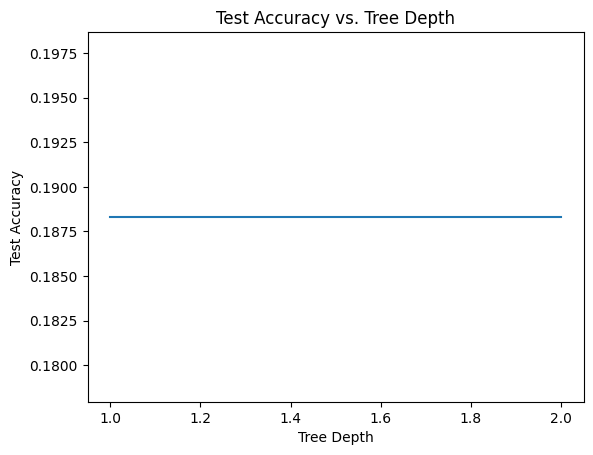

In [18]:
depths = list(range(1, tree_depth(tree) + 1))   # List of tree depths to try
accuracies = []                                 # List to store accuracies corresponding to each depth
# print(depths)
for depth in depths:
    pruned_tree = prune_tree(tree, validation_set, target_attribute, max_depth=depth)           
    test_predictions = [predict(pruned_tree, row) for _, row in test_data.iterrows()]
    accuracy = calculate_metrics(test_predictions, test_actual)[0]
    accuracies.append(accuracy)

# print(accuracies)
plt.plot(depths, accuracies)
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Tree Depth')
plt.show()